# Import data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install seaborn --user
# !pip install image-classifiers
# !pip install tensorflow==1.14.0
# !pip install tensorflow-gpu==1.14.0
# !pip install keras-vis
# !pip install --upgrade scikit-image

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
import random
import seaborn as sns
import vis ## keras-vis

from keras import optimizers, callbacks, Model
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn import datasets, metrics
from vis.utils import utils
from vis.visualization import visualize_cam, visualize_saliency
from keras import activations

print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))
# %matplotlib inline

Using TensorFlow backend.


keras      2.2.4
tensorflow 1.13.1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8848433225976817186
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3042124504936360499
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2319782330816909641
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12828635171250612901
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [5]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/home/ubuntu/landmarks/landmarks'
target_size = (224, 224)
input_shape = (224, 224, 3)

sample_generator = sample_datagen.flow_from_directory(base_path + '/subset_train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/subset_test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

classes = [x for x in sample_generator.class_indices.keys()]
total_classes = np.max(sample_generator.labels) + 1

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % total_classes,
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)
print(sample_generator.class_indices)
print(classes)

Found 12508 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


Showing y sample: [ 7. 15.  7.  5.  2.  2. 16. 19.  7.  5. 17. 10. 18. 14.  2.  3. 19. 12.
 17.  3.  2.  5. 14.  8.  8. 14. 11. 18. 10. 19. 18.  9.]


samples in train: 12508
samples in test: 3128
features: (224, 224, 3)
classes: 20

shape: (32, 224, 224, 3) (32, 224, 224, 3)
{'101399': 0, '120885': 1, '142644': 2, '146250': 3, '152827': 4, '165596': 5, '173511': 6, '178519': 7, '180901': 8, '186080': 9, '190822': 10, '20102': 11, '21253': 12, '31531': 13, '38482': 14, '47378': 15, '48522': 16, '56827': 17, '85758': 18, '97734': 19}
['101399', '120885', '142644', '146250', '152827', '165596', '173511', '178519', '180901', '186080', '190822', '20102', '21253', '31531', '38482', '47378', '48522', '56827', '85758', '97734']


## Lendo as 32 primeiras amostras no conjunto de treinamento

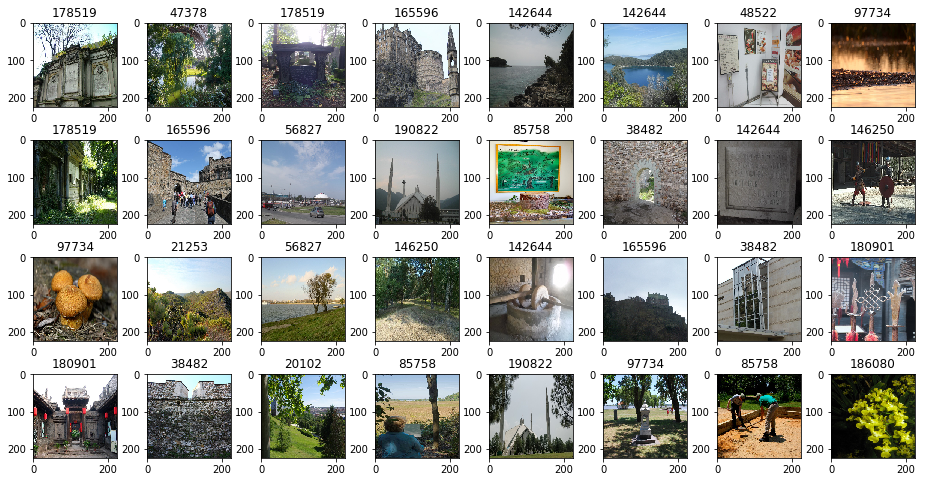

In [6]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

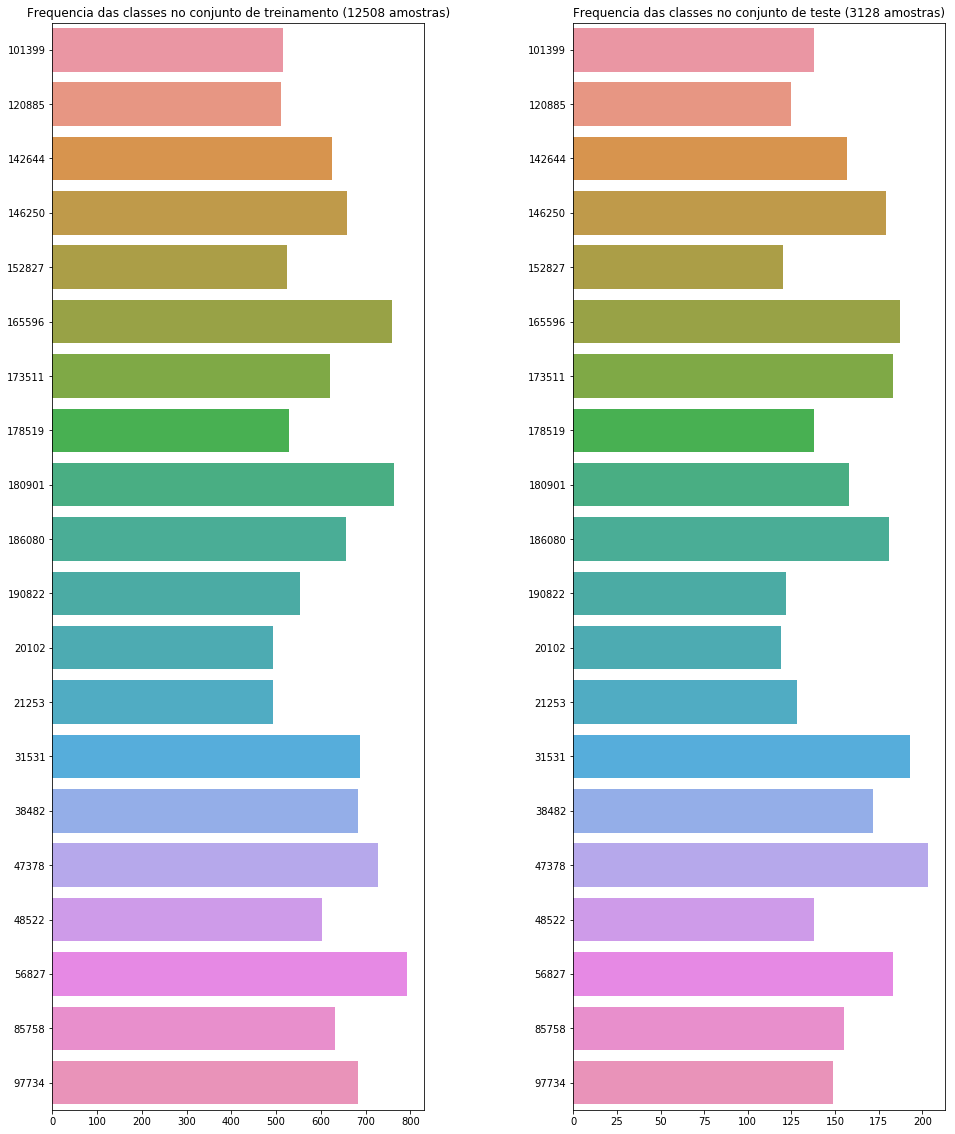

In [7]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [8]:
train_batch_size = 32 
val_batch_size = 32 

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

Found 10016 images belonging to 20 classes.
Found 2492 images belonging to 20 classes.


# Parâmetros para treinamento e validação

In [9]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

opt = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

basic_model = ResNet50(input_shape = input_shape,
                 weights = "imagenet",
                 include_top=False)

preprocess_input_model = preprocess_input

networkName = 'ResNet50-Tuning'

device = '/gpu:0'

epochs = 16

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Funções de auxílio

In [10]:
def model(base_model, name):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(name = 'global_mdc')(x)

    # add fully-connected layer
    x = Dense(512, activation='relu', name = 'dense_mdc')(x)

    # add output layer
    predictions = Dense(total_classes, activation='softmax', name = 'saida_mdc')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False

    # update the weight that are added
    print('============== update weight that ared added ==============')
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    with tf.device(device):
      model.fit_generator(generator = train_generator,
                          steps_per_epoch = train_steps,
                          epochs = epochs // 4,
                          verbose = 1,
                          validation_data = validation_generator,
                          validation_steps = validation_steps,
                          callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         verbose=1)])

    # choose the layers which are updated by training
    layer_num = utils.find_layer_idx(model, 'dense_mdc')
    for layer in model.layers:
        layer.trainable = True

    # update the weights

    print('============== fine tunning weights ==============')
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    with tf.device(device):
      history = model.fit_generator(generator = train_generator,
                                    steps_per_epoch = train_steps,
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps,
                                    callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         verbose=1)])
                    
    return history, model

In [11]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [12]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [13]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [14]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [15]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [16]:
def evaluate_model(model, name, generator = validation_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/4)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/4)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/4)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/4)****')
  evaluate_generator_model(model, name + '_val', generator, steps)
  evaluate_generator_model(model, name + '_train', train_generator, train_steps)

# ResNet50- Transfer Learning

## Fine Tuning

### Definindo a rede and training

In [39]:
history, tunning_model = model(basic_model, networkName)
tunning_model.save('./final.model.' + networkName + '.h5')

============== update weight that ared added ==============
Epoch 1/4
313/313 [==============================] - 112s 358ms/step - loss: 1.0561 - val_loss: 1.6612

Epoch 00001: val_loss improved from inf to 1.66121, saving model to ./ResNet50-Tuning.weights.h5
Epoch 2/4
313/313 [==============================] - 102s 325ms/step - loss: 0.6186 - val_loss: 1.4831

Epoch 00002: val_loss improved from 1.66121 to 1.48309, saving model to ./ResNet50-Tuning.weights.h5
Epoch 3/4
313/313 [==============================] - 102s 327ms/step - loss: 0.4303 - val_loss: 1.8223

Epoch 00003: val_loss did not improve from 1.48309
Epoch 4/4
313/313 [==============================] - 102s 326ms/step - loss: 0.4263 - val_loss: 1.6643

Epoch 00004: val_loss did not improve from 1.48309
============== fine tunning weights ==============
Epoch 1/16
313/313 [==============================] - 317s 1s/step - loss: 0.2753 - acc: 0.9557 - val_loss: 1.4350 - val_acc: 0.7732

Epoch 00001: val_loss improved from inf

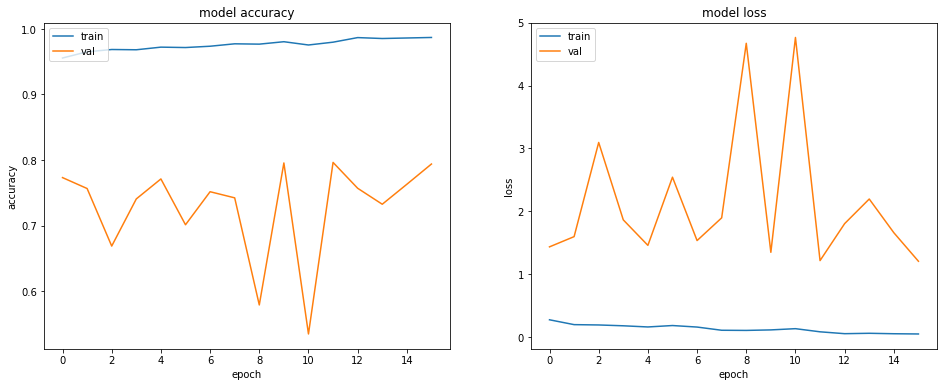

In [40]:
learning_curve_model(history)

## Evaluating model

In [17]:
from keras.models import load_model

tunning_model = load_model('./final.model.' + networkName + '.h5')
tunning_model.summary()

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________________________________

*** Prediction model - Part (1/4)****
*** Classification model - Part (2/4)****
              precision    recall  f1-score   support

      101399       0.83      0.64      0.72        39
      120885       0.61      0.84      0.71        43
      142644       0.95      0.64      0.76        55
      146250       0.96      0.91      0.93        55
      152827       0.56      0.71      0.63        42
      165596       0.86      0.73      0.79        59
      173511       0.91      0.98      0.95        54
      178519       0.91      0.93      0.92        45
      180901       0.71      0.85      0.77        60
      186080       0.83      0.90      0.86        63
      190822       0.98      0.94      0.96        48
       20102       0.93      0.81      0.87        48
       21253       0.83      0.72      0.77        47
       31531       0.90      0.80      0.85        45
       38482       0.82      0.89      0.85        55
       47378       0.90      0.95      0.93        59
 

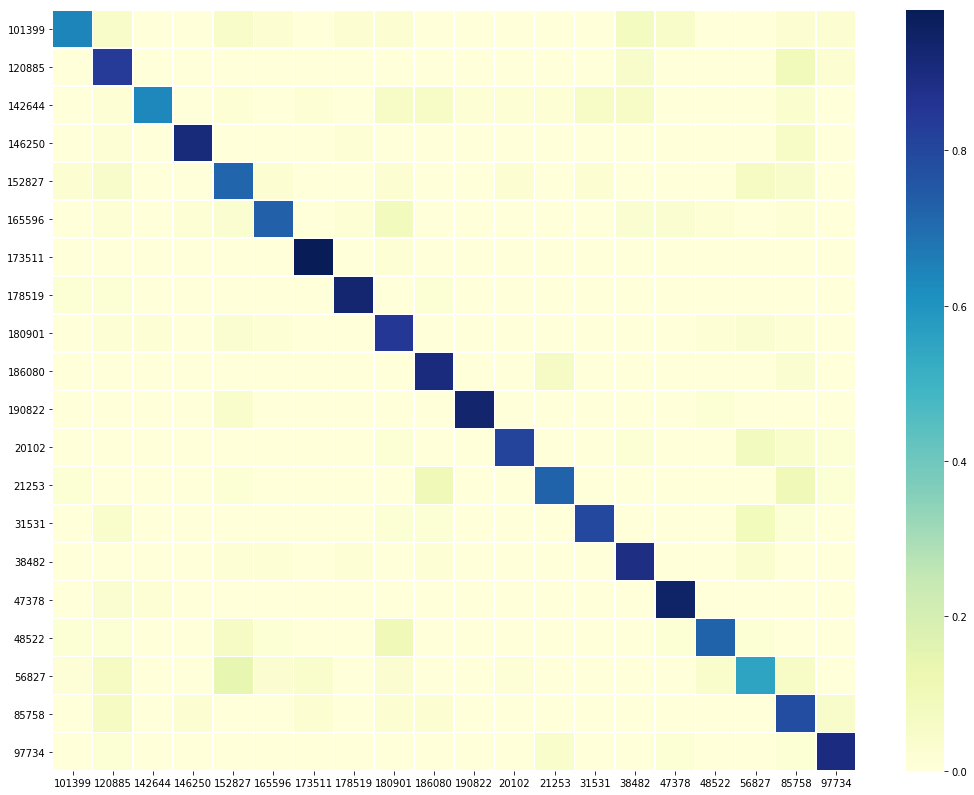


Classes incorretamente classificadas pelo modelo, com maior frequência:
  56827: 0.5507246376811594
 142644: 0.6363636363636364
 101399: 0.6410256410256411
 152827: 0.7142857142857143
 48522: 0.723404255319149
 21253: 0.723404255319149
 165596: 0.7288135593220338
 85758: 0.7857142857142857
 31531: 0.8
 20102: 0.8125


Classes incorretamente classificadas pelo modelo, com menor frequência:
  173511: 0.9814814814814815
 47378: 0.9491525423728814
 190822: 0.9375
 178519: 0.9333333333333333
 146250: 0.9090909090909091
 186080: 0.9047619047619048
 97734: 0.8979591836734694
 38482: 0.8909090909090909
 180901: 0.85
 120885: 0.8372093023255814

*** Evaluate model - Part (4/4)****
[ResNet50-Tuning_val] loss: 1.2254128036173908
[ResNet50-Tuning_val] accuracy (NOT BALANCED): 0.7950487012987013
[ResNet50-Tuning_train] loss: 0.05669024637446533
[ResNet50-Tuning_train] accuracy (NOT BALANCED): 0.9827276357827476


In [41]:
evaluate_model(tunning_model, networkName) 

## Check error

shape sample: (32, 224, 224, 3)
label: 2


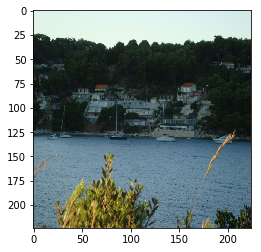

Top 1 predicted class:     Pr(Class=142644             [index=2])=0.9998
Top 2 predicted class:     Pr(Class=146250             [index=3])=0.0001
Top 3 predicted class:     Pr(Class=31531              [index=13])=0.0001
Top 4 predicted class:     Pr(Class=180901             [index=8])=0.0000
Top 5 predicted class:     Pr(Class=120885             [index=1])=0.0000


In [107]:
validation_generator.reset()

x_sample, y_sample = validation_generator.next()
print('shape sample:', x_sample.shape)
print('label:', np.argmax(y_sample[0], axis=-1) )
plt.imshow(x_sample[0])
plt.show()

y_pred = tunning_model.predict(x_sample)
class_idxs_sorted = np.argsort(y_pred[0].flatten())[::-1]
topNclass = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.4f}"
          .format(i + 1, classes[idx], idx, y_pred[0,idx]))

In [57]:
# gradient weighted class activation map (Grad-CAM)
layer_idx = utils.find_layer_idx(tunning_model, 'saida_mdc')
final_conv_layer = utils.find_layer_idx(tunning_model, 'res5c_branch2c')

In [66]:
# swap softmax with linear
tunning_model.layers[layer_idx].activation = activations.linear
model_mod = utils.apply_modifications(tunning_model)

Text(0.5, 0.98, 'Pr(class=142644) =  1.00')

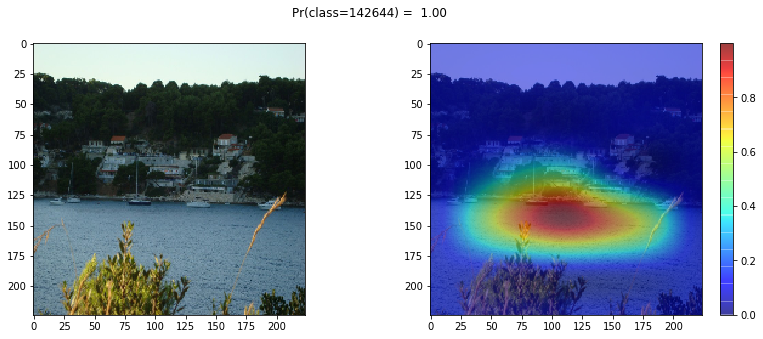

In [109]:
class_idx  = class_idxs_sorted[0]
seed_input = x_sample[0]

grad_top1  = visualize_cam(model_mod, 
                           layer_idx, 
                           class_idx, 
                           seed_input, 
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier = None,
                           grad_modifier = None)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(seed_input)
axes[1].imshow(seed_input)
i = axes[1].imshow(grad_top1,cmap="jet",alpha=0.5)
fig.colorbar(i)
fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

In [112]:
def plot_map(orignal, grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(orignal)
    axes[1].imshow(orignal)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

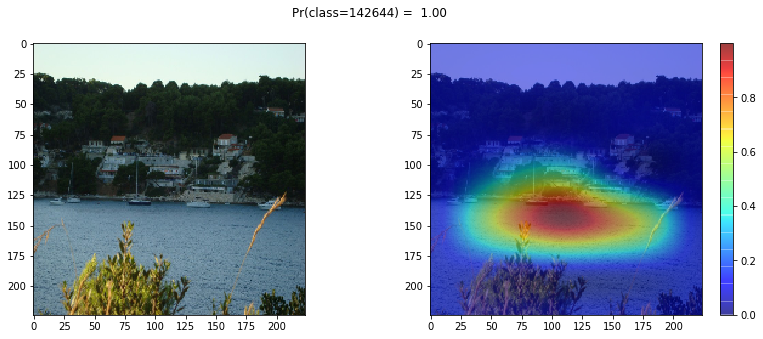

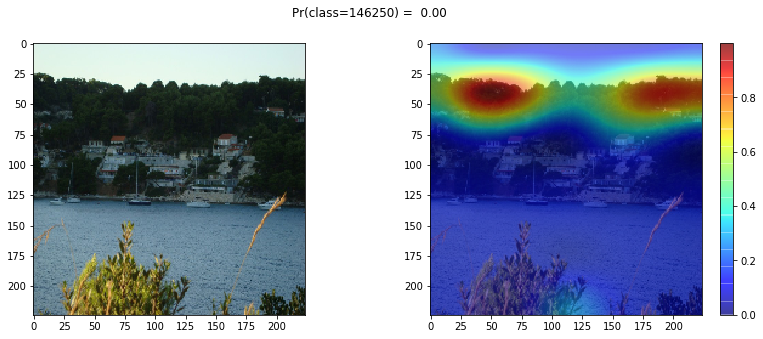

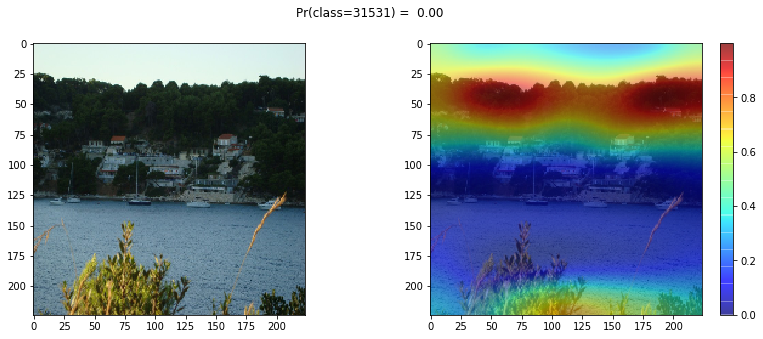

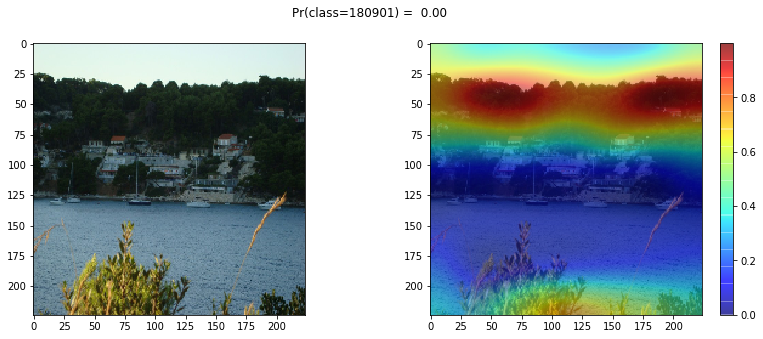

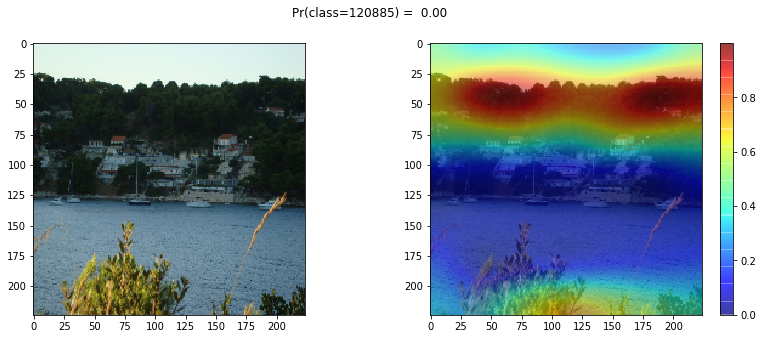

In [113]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model_mod,
                           layer_idx,
                           class_idx, 
                           seed_input,
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(seed_input, grads)